In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
import cv2
import datagen
import model as unet_model_script
import random
import matplotlib.pyplot as plt
import importlib
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
importlib.reload(datagen)
importlib.reload(unet_model_script)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

In [3]:
image_size = 240
num_slices = 20

# Image postprocessing

In [4]:
x_val, y_val = datagen.get_whole_patient(number=1, 
                  file_path='../dataset/', 
                  mode='training', 
                  glioma_type=['HGG'], 
                  image_size=240                     
                )
x_val.shape

(1, 155, 4, 240, 240)

### get_predictions

Loads models and returns predictions based on x.

:param `path`: path used to load models  
:param `name`: model name appended to path  
:param `x`: data to use for predictions  
:param `a`: tumor region label from  
:param `b`: tumor region label to  

:`return`: predictions

In [5]:
def get_predictions(path, name, x, a, b, verbose=0):
    models = {}
    predictions = {}
    for tumor_region in range(a, b+1):
        if verbose==1: print("Loading model", path + name + "_" + "{}.h5".format(tumor_region))
        models[tumor_region] = keras.models.load_model(path + name + "_" + "{}.h5".format(tumor_region))
        predictions[tumor_region] = models[tumor_region].predict(x, verbose=verbose)
    return predictions

### create_mask

:param `predictions`: dict of prediction lists for each tumor class (1..4), where each list contains all slices segmented  
:param `num_slices`: integer, describes the length of each list in predictions  
:param `image_size`: integer, describes image size (x, y)  
:param `p`: float, sets the threshold value of which pixels to use in the final mask  

:`return`: final mask as numpy array with dimensions (num_slices, image_size, image_size)

In [6]:
def create_mask(predictions, num_slices, image_size, p=0.5):
    
    final_mask = np.zeros((num_slices, 1, image_size, image_size))
    
    for k in predictions.keys():
        final_mask[predictions[k] >= p] = k

    return np.nan_to_num(final_mask) # replace all nan values with 0

In [7]:
predictions_1 = get_predictions("../experiment_data_selection/", "unet", x_val[0], 1, 3, verbose=1)

Loading model ../experiment_data_selection/unet_1.h5
155/155 [==============================] - 9s 60ms/step
Loading model ../experiment_data_selection/unet_2.h5
155/155 [==============================] - 3s 22ms/step
Loading model ../experiment_data_selection/unet_3.h5
155/155 [==============================] - 3s 22ms/step


In [ ]:
final_mask = create_mask(predictions, 155, image_size, p=0.5)

89


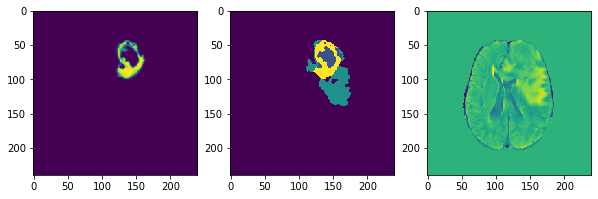

In [8]:
i = random.randint(70, 100)
# i=76
print(i)
# print(np.unique(final_mask[i][0]))
# print(np.unique(y_val[0][i][0]))

# Plot
f, axarr = plt.subplots(1,3, figsize=(10,10))
# axarr[0].imshow(final_mask[i][0])
axarr[0].imshow(predictions_1[1][i][0])
axarr[1].imshow(y_val[0][i][0])
axarr[2].imshow(x_val[0][i][0])

-- min, max chyba, std, mean pre kazdeho pacienta
-- skusit hybat prah 0.5 na 0.45 0.55
-- vyhodnotit: base, base + dropout(0.5), base + dropout(0.2), 
-- skusit uzavriet regiony a porovnat chyby
-- postprocessing -- uzatvara diery v segmentacii. Da sa to d obinaru, zoberie sa vonkajsia kontura.. (openCV

-- spravne vyfarbit jednotlive kategorie + pridat legendu, aby bolo jasne vidno co kam patri
-- zvyraznit hustotu tkaniva 

-- vyhodnotit pomocou cisel hlavne
-- pridat vizualizacie, aby sa lahsie vysvetlovali vystupy,

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2 * |X & Y|)/ (|X| + |Y|)
         =  2  *sum(|A * B|)/(sum(A ^ 2)+sum(B ^ 2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    source: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
    """
    # Change dtype
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    axis=None
    intersection = K.sum(K.abs(y_true * y_pred), axis=axis)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),axis) + K.sum(K.square(y_pred),axis) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
dice_coef(y_val[0],final_mask).numpy()

In [ ]:
np.average(keras.metrics.binary_accuracy(y_val[0],final_mask, threshold=0.5))

In [10]:
idx = 0

In [11]:
y_val_converted_1 = datagen.convert_labels(y_val[idx], 3, image_size)

In [12]:
predictions_1[1][predictions_1[1] >= 0.5] = 1
predictions_1[2][predictions_1[2] >= 0.5] = 1
predictions_1[3][predictions_1[3] >= 0.5] = 1

In [13]:
print(predictions_1[1].shape)
print(y_val[0].shape)

(155, 1, 240, 240)
(155, 1, 240, 240)


In [14]:
print(dice_coef(y_val_converted_1,predictions_1[1]).numpy())
print(dice_coef(y_val_converted_1,predictions_1[2]).numpy())
print(dice_coef(y_val_converted_1,predictions_1[3]).numpy())
print()

0.875773
0.9223857
0.8906915



In [15]:
np.average([0.8827838, 0.7477297, 0.7881683, 0.73876697, 0.8932085, 0.5412327, 0.8308219, 0.76022285, 0.83578587, 0.714912, 0.875773])

0.7826732354545456

In [16]:
np.average([0.8830972, 0.74346673, 0.80831933, 0.75861424, 0.8897082, 0.5665246, 0.8340987, 0.78054976, 0.89531505, 0.72126126, 0.9223857])

0.8003037063636363

In [17]:
np.average([0.88439703, 0.72430116, 0.80253154, 0.80975336, 0.89849716, 0.6712342, 0.8471954, 0.770648, 0.88621205, 0.714238, 0.8906915])

0.8090635818181817